In [20]:
'''
%pip uninstall -y community
%pip uninstall -y community-louvain
%pip uninstall -y python-louvain
'''

'\n%pip uninstall -y community\n%pip uninstall -y community-louvain\n%pip uninstall -y python-louvain\n'

In [21]:
'''
%pip install geopandas
%pip install shapely.geometry
%pip install osmnx
%pip install python-louvain
%pip install folium
%pip install folium.plugins
'''

'\n%pip install geopandas\n%pip install shapely.geometry\n%pip install osmnx\n%pip install python-louvain\n%pip install folium\n%pip install folium.plugins\n'

## Import Libraries

In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import osmnx as ox
import networkx as nx
import community.community_louvain as community_louvain
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Load Accident Data

In [23]:
def load_accidents(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    if "Accident_Severity" not in df.columns:
        raise ValueError("Missing column: Accident_Severity")
    df["severity"] = df["Accident_Severity"].astype(int)

    if "Date" not in df.columns or "Time" not in df.columns:
        raise ValueError("CSV must contain Date and Time columns")
    df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)

    if not {"latitude", "longitude"}.issubset(df.columns):
        raise ValueError("CSV must include latitude and longitude columns")

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
    return gdf


In [24]:
def filter_to_delhi(gdf):
    return gdf[
        (gdf["latitude"] >= 28.4) &
        (gdf["latitude"] <= 28.9) &
        (gdf["longitude"] >= 76.8) &
        (gdf["longitude"] <= 77.4)
    ].copy()

## Get Road Network

In [25]:
def get_network_from_osm(center_point=None, dist=2000, network_type='drive'):
    if center_point is None:
        raise ValueError("Provide center_point=(lat, lon) to download OSM network")

    lat, lon = center_point
    G = ox.graph_from_point((lat, lon), dist=dist, network_type=network_type)
    G_proj = ox.project_graph(G)
    return G_proj


## Snap accidents to nearest node & aggregate

In [26]:
def snap_accidents_to_nodes(G, accidents_gdf):
    """
    Map each accident to the nearest node in the projected graph.
    
    G: projected OSMnx graph
    accidents_gdf: GeoDataFrame in EPSG:4326
    Returns a DataFrame mapping accident index -> nearest node id.
    """
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.reset_index().rename(columns={'osmid': 'node'})
    
    acc_proj = accidents_gdf.to_crs(nodes_gdf.crs)

    from scipy.spatial import cKDTree
    node_coords = np.vstack((nodes_gdf.geometry.x.values, nodes_gdf.geometry.y.values)).T
    acc_coords = np.vstack((acc_proj.geometry.x.values, acc_proj.geometry.y.values)).T

    kdt = cKDTree(node_coords)
    dists, idxs = kdt.query(acc_coords, k=1)
    node_ids = nodes_gdf.loc[idxs, 'node'].values

    mapping_df = pd.DataFrame({
        'acc_index': acc_proj.index,
        'node': node_ids,
        'distance_m': dists
    })

    mapping_df = mapping_df.join(accidents_gdf.reset_index(drop=False).set_index('index'), on='acc_index', how='left')
    return mapping_df


## Compute Aggregated Metrics & Centralities

In [27]:
def compute_node_metrics(G, mapping_df):
    """
    Compute aggregated accident metrics and centralities for each node.

    G: projected OSMnx graph
    mapping_df: DataFrame from snap_accidents_to_nodes
    Returns a GeoDataFrame with accident counts, centralities, and risk_score.
    """
    import networkx as nx
    from sklearn.preprocessing import MinMaxScaler

    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
    nodes_gdf = nodes_gdf.copy()
    nodes_gdf["node"] = nodes_gdf.index

    # Aggregate accidents per node
    agg = mapping_df.groupby("node").agg(
        accident_count=("acc_index", "count"),
        avg_severity=("severity", "mean")
    ).reset_index()

    merged = nodes_gdf.merge(agg, on="node", how="left")
    merged["accident_count"] = merged["accident_count"].fillna(0)
    merged["avg_severity"] = merged["avg_severity"].fillna(0)

    # Compute centralities
    Gu = G.to_undirected()
    deg = nx.degree_centrality(Gu)
    bet = nx.betweenness_centrality(Gu, k=min(300, max(5, len(Gu)//10)), seed=42)
    clo = nx.closeness_centrality(Gu)
    try:
        eig = nx.eigenvector_centrality_numpy(Gu)
    except:
        eig = {n: 0 for n in Gu.nodes()}

    merged["degree_c"] = merged["node"].map(deg).fillna(0)
    merged["betweenness_c"] = merged["node"].map(bet).fillna(0)
    merged["closeness_c"] = merged["node"].map(clo).fillna(0)
    merged["eigenvector_c"] = merged["node"].map(eig).fillna(0)

    # Scale metrics and compute risk score
    scaler = MinMaxScaler()
    metrics = merged[[
        "accident_count","avg_severity",
        "degree_c","betweenness_c","closeness_c","eigenvector_c"
    ]]
    scaled = pd.DataFrame(scaler.fit_transform(metrics), columns=[
        "accident_count_s","avg_severity_s",
        "degree_s","betweenness_s","closeness_s","eigenvector_s"
    ])
    merged = pd.concat([merged.reset_index(drop=True), scaled], axis=1)

    merged["risk_score"] = (
        0.4*merged["accident_count_s"] +
        0.2*merged["avg_severity_s"] +
        0.2*merged["betweenness_s"] +
        0.1*merged["degree_s"] +
        0.1*((merged["eigenvector_s"] + merged["closeness_s"])/2)
    )

    return merged


## Community Detection on Node-Risk Graph

In [28]:
def detect_communities(G, nodes_gdf, weight_col='risk_score'):
    """
    Run Louvain community detection on the graph.
    Returns a partition dict (node -> community) and adds a 'community' column to nodes_gdf.
    """
    Gu = G.to_undirected()
    edge_weight = nx.get_edge_attributes(Gu, "weight")
    for u, v, data in Gu.edges(data=True):
        data['weight'] = float(edge_weight.get((u, v), 1.0))

    partition = community_louvain.best_partition(Gu, weight="weight")
    nodes_gdf["community"] = nodes_gdf["node"].map(partition).fillna(-1).astype(int)

    return partition, nodes_gdf

## Identify top-k hotspots & export

In [29]:
def get_top_k_nodes(nodes_gdf, k=20):
    return nodes_gdf.sort_values('risk_score', ascending=False).head(k)


def export_results(nodes_gdf, filepath_csv='node_metrics.csv', filepath_geojson='node_metrics.geojson'):
    nodes_gdf.to_file(filepath_geojson, driver='GeoJSON')
    nodes_gdf.drop(columns='geometry').to_csv(filepath_csv, index=False)
    print(f"Exported CSV -> {filepath_csv}, GeoJSON -> {filepath_geojson}")


## Visualizations

In [30]:
def plot_map_static(nodes_gdf, edges_gdf=None, top_k=20, figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    if edges_gdf is not None:
        edges_gdf.plot(ax=ax, linewidth=0.7, alpha=0.6)
    nodes_gdf.plot(column='risk_score', ax=ax, markersize=nodes_gdf['risk_score']*200, legend=True)
    top = get_top_k_nodes(nodes_gdf, k=top_k)
    top.plot(ax=ax, color='red', markersize=40, label='Top hotspots')
    plt.title('Node Risk Score (static)')
    plt.axis('off')
    plt.legend()
    plt.show()


import branca.colormap as cm

def folium_interactive_map(nodes_gdf, edges_gdf=None, center=None, zoom_start=13):
    nodes_latlon = nodes_gdf.to_crs(epsg=4326)
    if center is None:
        center = [nodes_latlon.geometry.y.mean(), nodes_latlon.geometry.x.mean()]
    m = folium.Map(location=center, zoom_start=zoom_start)

    risk_min = nodes_latlon['risk_score'].min()
    risk_max = nodes_latlon['risk_score'].max()
    colormap = cm.linear.YlOrRd_09.scale(risk_min, risk_max)
    colormap.caption = 'Node Risk Score'
    colormap.add_to(m)

    for _, row in nodes_latlon.iterrows():
        folium.CircleMarker(
            location=(row.geometry.y, row.geometry.x),
            radius=3 + float(row['risk_score']*10),
            color=colormap(row['risk_score']),
            fill=True,
            fill_color=colormap(row['risk_score']),
            fill_opacity=0.7,
            popup=folium.Popup(
                f"node: {row['node']}<br>risk: {row['risk_score']:.3f}<br>accidents: {int(row['accident_count'])}",
                max_width=250
            )
        ).add_to(m)

    if edges_gdf is not None:
        edges_latlon = edges_gdf.to_crs(epsg=4326)
        for _, row in edges_latlon.iterrows():
            coords = [(pt[1], pt[0]) for pt in row.geometry.coords] if isinstance(row.geometry, LineString) else []
            if coords:
                folium.PolyLine(locations=coords, weight=2, opacity=0.4).add_to(m)

    return m


## Pipeline Runner

In [31]:
def run_pipeline(accident_csv, center_point, dist=3000, top_k=25, export_prefix='results'):
    print("Loading accidents...")
    acc_gdf = load_accidents(accident_csv)

    print("Filtering to Delhi region…")
    acc_gdf = filter_to_delhi(acc_gdf)
    if acc_gdf.empty:
        raise ValueError("No accidents found in Delhi bounds!")

    print("Downloading road network with OSMnx...")
    G = get_network_from_osm(center_point=center_point, dist=dist)

    print("Snapping accidents to nodes...")
    mapping_df = snap_accidents_to_nodes(G, acc_gdf)

    print("Computing node metrics...")
    nodes_gdf = compute_node_metrics(G, mapping_df)

    print("Detecting communities...")
    _, nodes_gdf = detect_communities(G, nodes_gdf)

    nodes_gdf_proj, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    top_nodes = get_top_k_nodes(nodes_gdf, k=top_k)

    print("Top hotspots (node, risk, accident_count):")
    print(top_nodes[['node','risk_score','accident_count']].head(top_k))

    export_results(nodes_gdf,
                   filepath_csv=f'{export_prefix}_nodes.csv',
                   filepath_geojson=f'{export_prefix}_nodes.geojson')

    plot_map_static(nodes_gdf, edges_gdf)
    m = folium_interactive_map(nodes_gdf, edges_gdf)
    m.save(f"{export_prefix}_map.html")
    print(f"Interactive map saved to {export_prefix}_map.html")

    return nodes_gdf, top_nodes, m


C:\Users\lenovo\AppData\Local\Temp\ipykernel_25012\2781513053.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)


Loading accidents...


C:\Users\lenovo\AppData\Local\Temp\ipykernel_25012\2781513053.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)


Filtering to Delhi region…
Snapping accidents to nodes...
Computing node metrics...
Detecting communities...
Top hotspots (node, risk, accident_count):
             node  risk_score  accident_count
1106   1902764804    0.622239          1882.0
14     6742341898    0.539250          1519.0
4       175610054    0.466489             1.0
917    1681456950    0.443718          1079.0
907     395135061    0.433190          1008.0
1226   6655403218    0.420020             1.0
1896   9835234362    0.405615             1.0
10      250078355    0.405388             1.0
1052   1867171631    0.399284             1.0
259     309862883    0.388435             1.0
257    6657116887    0.383148             1.0
70     2432410424    0.375771             1.0
601     939284650    0.374010             1.0
1619   5483954454    0.364667           676.0
958   11837277569    0.363916             1.0
251    1870091833    0.362735             2.0
72      563659525    0.361998             1.0
1049   2431986014   

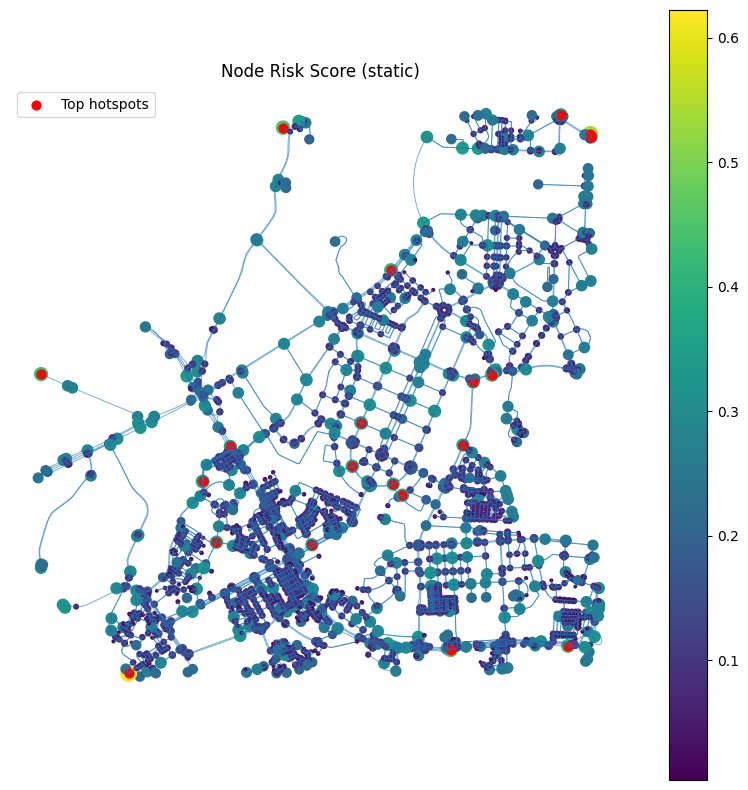

Interactive map saved to delhi_accident_analysis_map.html


In [32]:
if __name__ == "__main__":
    
    csv_path = "AccidentsBig.csv"

    acc_gdf = load_accidents(csv_path)
    acc_gdf = filter_to_delhi(acc_gdf)

    center_point = (acc_gdf["latitude"].mean(), acc_gdf["longitude"].mean())

    nodes_gdf, top_nodes, m = run_pipeline(
        csv_path,
        center_point=center_point,
        dist=3000,          # 3km radius around Delhi center
        top_k=25,
        export_prefix="delhi_accident_analysis"
    )
